In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new/")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

from tensorflow_probability.substrates import jax as tfp

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# TriplePandelSPE/JAX stuff
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.smaller_network_eqx import get_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track
from likelihood_conv_mpe_w_noise import get_neg_c_triple_gamma_llh

import optax
import blackjax
import jaxns

import time

In [2]:
# Event Index.
event_index = 0
# Get network and eval logic.
dtype = jnp.float64
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/smaller_network_eqx/tpn_smallest_default_tree_start_epoch_192', dtype=jnp.float64)
#eval_network_v = get_network_eval_v_fn(bpath="/home/storage/hans/photondata/train_in_jax/cache_z_and_dist_penalty/w_z_and_dist_penalty_tpn_smallest_default_tree_start_epoch_190.eqx", dtype=jnp.float64)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=jnp.float64)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'

#sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
#                              os.path.join(bp, 'pulses_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
#                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

muon energy: 2.1 TeV


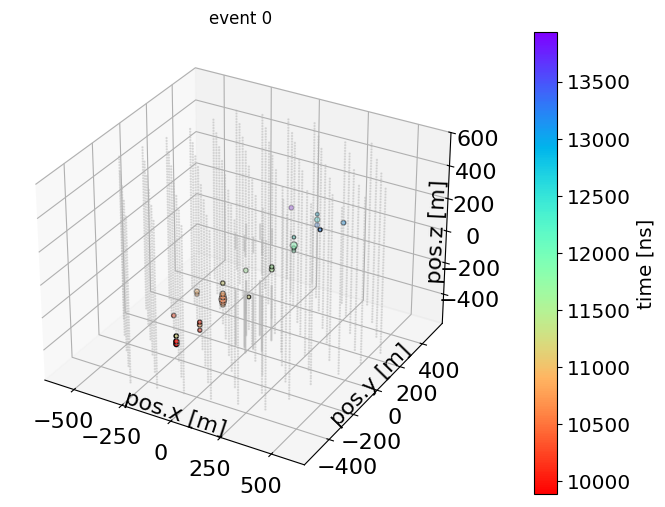

In [3]:
            # Plot event.
            fig = plt.figure(figsize=(8,6))
            ax = plt.subplot(projection='3d')
            ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
            ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
            ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)
            ax.set_title(f'event {event_index}')

            df = event_data
            idx = df['charge'] > 0
            geo = sim_handler.geo

            try:
                im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
            except:
                pass

            im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'],
                            cmap='rainbow_r',  edgecolors='k', zorder=1000)
            ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
            cb = plt.colorbar(im, orientation="vertical", pad=0.1)
            cb.set_label(label='time [ns]', size='x-large')
            cb.ax.tick_params(labelsize='x-large')
            plt.show()

In [4]:
# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

original seed vertex: [-1277.51128861 -1390.39564543 -1675.98024553]
shifted seed vertex: [ -53.74394146  162.12452256 -233.73599134]


In [5]:
print(np.rad2deg(track_src))

[126.11328806 231.75320629]


In [6]:
print(centered_track_pos)

[ -53.74394146  162.12452256 -233.73599134]


In [7]:
# Clip charge and combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())
print(fitting_event_data.shape)

# Setup likelihood
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)
print(neg_llh(track_src, centered_track_pos, centered_track_time, fitting_event_data))

(29, 5)
536.9684660550313


In [8]:
'''
scale = 100.0
def log_p(x1, x2, x3, x, y, z):
    v = jnp.array([x1, x2, x3])
    v = v / jnp.linalg.norm(v)
    azimuth = jnp.atan2(v[1], v[0])
    azimuth = jnp.where(azimuth >= 0, azimuth, 2.0*jnp.pi + azimuth)
    zenith = jnp.arccos(v[2])
    projected_dir = jnp.array([zenith, azimuth])
    
    x = jnp.array([x, y, z])
    
    return -0.5*neg_llh(projected_dir, x*scale, centered_track_time, fitting_event_data)
'''

In [67]:
X = model.transform(U=results.U_samples)

TypeError: reshape total size must be unchanged, got new_sizes () (of total size 1) for shape (1, 5) (of total size 5).

In [9]:
tfpd = tfp.distributions

from jaxns.framework.model import Model
from jaxns.framework.prior import Prior

In [105]:

def prior_model():
    x1 = yield Prior(tfpd.Normal(loc=0., scale=1.), name="dir_x")
    x2 = yield Prior(tfpd.Normal(loc=0., scale=1.), name="dir_y")
    x3 = yield Prior(tfpd.Normal(loc=0., scale=1.), name="dir_z")

    x = yield Prior(tfpd.Uniform(low=-500, high=500), name="vertex_x")
    y = yield Prior(tfpd.Uniform(low=-500, high=500), name="vertex_y")
    z = yield Prior(tfpd.Uniform(low=-500, high=500), name="vertex_z")
    return x1, x2, x3, x, y , z


In [106]:

def log_p(x1, x2, x3, x, y, z):
    v = jnp.array([x1, x2, x3])
    v = v / jnp.linalg.norm(v)
    azimuth = jnp.atan2(v[1], v[0])
    azimuth = jnp.where(azimuth >= 0, azimuth, 2.0*jnp.pi + azimuth)
    zenith = jnp.arccos(v[2])
    projected_dir = jnp.array([zenith, azimuth])
    
    x = jnp.array([x, y, z])
    
    return -0.5*neg_llh(projected_dir, x, centered_track_time, fitting_event_data)


In [30]:
centered_track_pos

Array([ -53.74394146,  162.12452256, -233.73599134], dtype=float64)

In [84]:
def prior_model():
    zenith = yield Prior(tfpd.Uniform(low=0, high=jnp.pi), name='zenith')
    azimuth = yield Prior(tfpd.Uniform(low=0, high=2.0*jnp.pi), name='azimuth')

    x = yield Prior(tfpd.Uniform(low=-500, high=500), name='vertex_x')
    y = yield Prior(tfpd.Uniform(low=-500, high=500), name='vertex_y')
    z = yield Prior(tfpd.Uniform(low=-500, high=500), name='vertex_z')
    return zenith, azimuth, x, y , z

In [85]:
def log_p(zenith, azimuth, x, y, z):
    projected_dir = jnp.array([zenith, azimuth])
    x = jnp.array([x, y, z])
    return -0.5*neg_llh(projected_dir, x, centered_track_time, fitting_event_data)

In [107]:
model = Model(prior_model=prior_model, log_likelihood=log_p)

In [108]:
from jaxns import NestedSampler

ns = NestedSampler(model=model, max_samples=1e4, num_live_points=100)#, difficult_model=True)
ns_jit = jax.jit(ns)
#ns_aot = jax.jit(ns).lower(jax.random.PRNGKey(42)).compile()

INFO:jaxns:Number of Markov-chains set to: 100


In [109]:
# Run the sampler
termination_reason, state = ns_jit(jax.random.PRNGKey(42))
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)

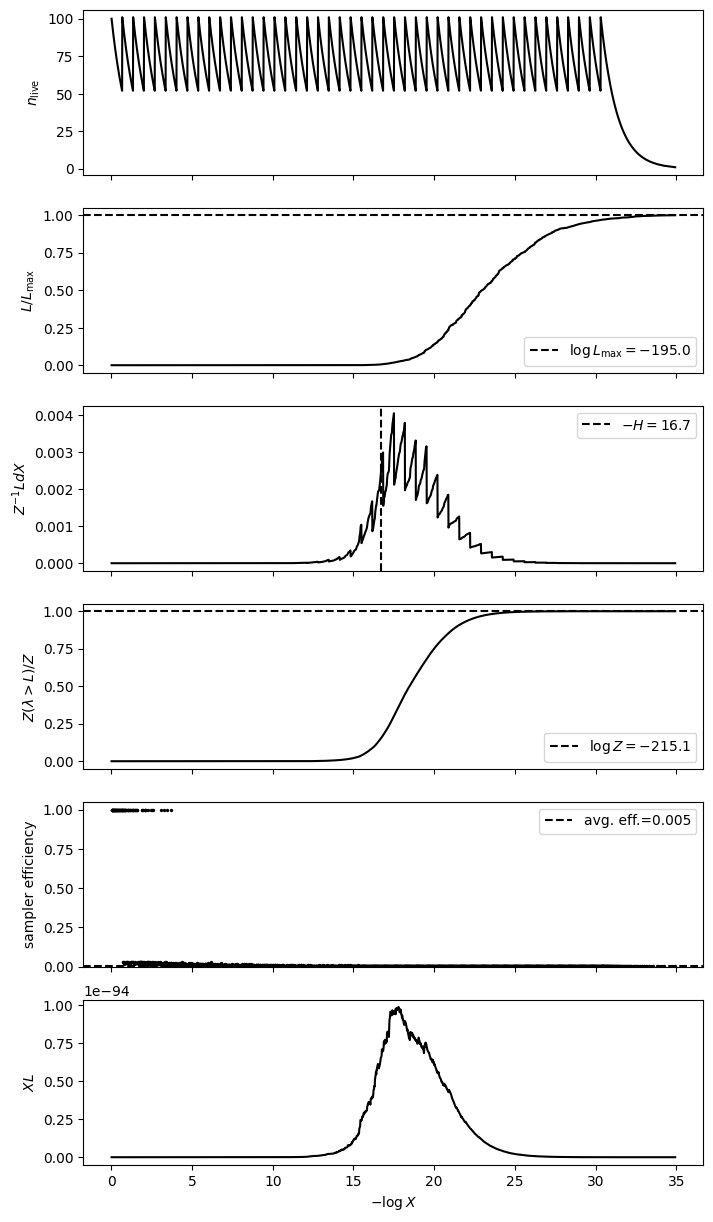

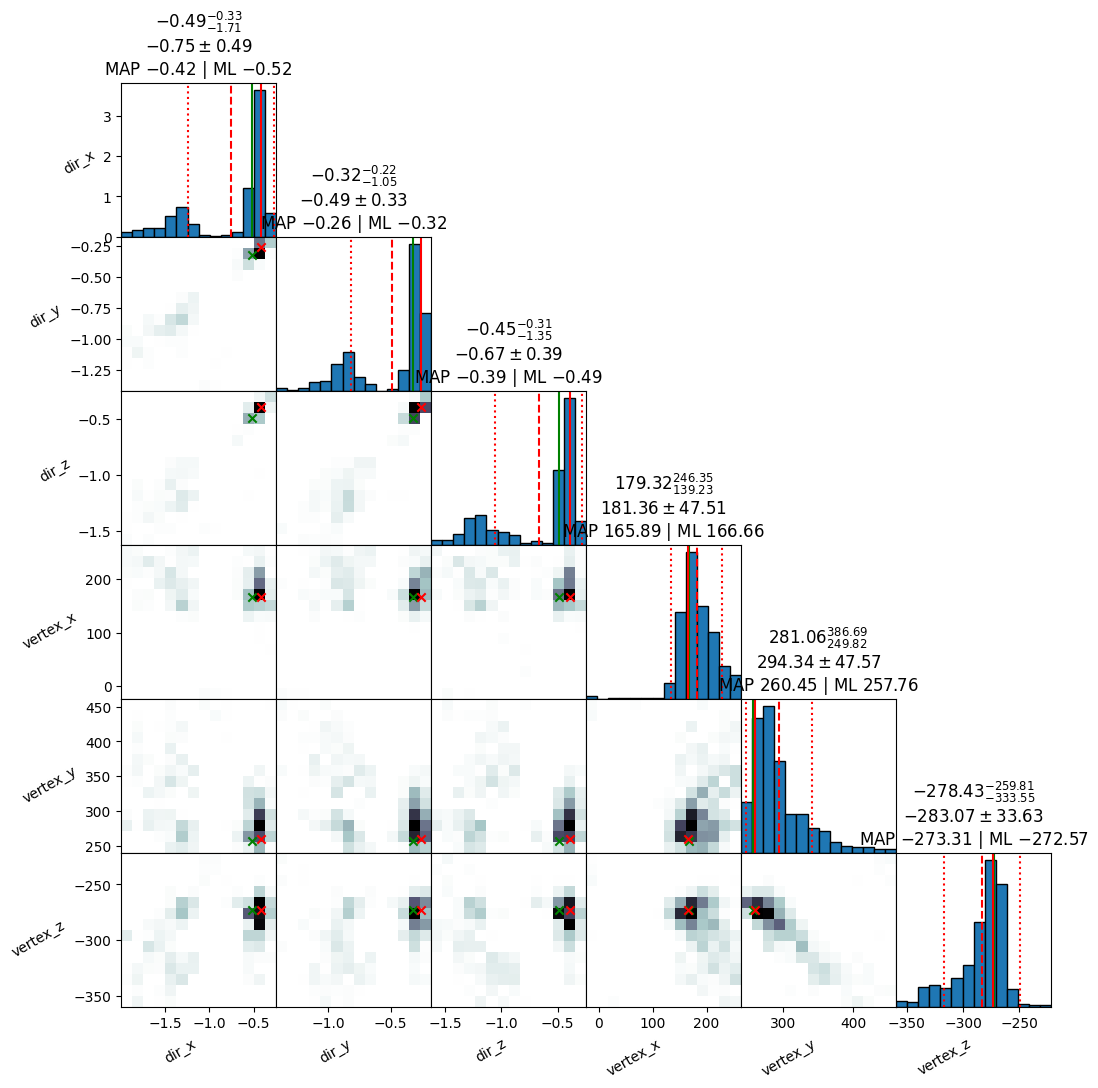

In [110]:
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)

In [90]:
print(centered_track_pos)

[ -53.74394146  162.12452256 -233.73599134]


In [91]:
solution = results.U_samples[jnp.argmax(results.log_L_samples)]

In [92]:
solution[:2]

Array([0.71414578, 0.587407  ], dtype=float64)

In [93]:
track_src

Array([2.20109211, 4.0448565 ], dtype=float64)

In [111]:
from jaxns import resample

samples = resample(
    key=jax.random.PRNGKey(0),
    samples=results.samples,
    log_weights=results.log_dp_mean,
    S=1000,
    replace=True
)

In [117]:
v = jnp.concatenate([jnp.expand_dims(samples['dir_z'], axis=1),
                     jnp.expand_dims(samples['dir_y'], axis=1), 
                      jnp.expand_dims(samples['dir_z'], axis=1)
                    ]
                    , axis=0)

In [118]:
v = v / jnp.linalg.norm(v, axis=1)

In [120]:
azimuth = jnp.atan2(v[1], v[0])
azimuth = jnp.where(azimuth >= 0, azimuth, 2.0*jnp.pi + azimuth)
zenith = jnp.arccos(v[2])

(array([   0.,    0.,    0.,    0.,    0., 3000.,    0.,    0.,    0.,
           0.]),
 array([254.43036743, 254.53036743, 254.63036743, 254.73036743,
        254.83036743, 254.93036743, 255.03036743, 255.13036743,
        255.23036743, 255.33036743, 255.43036743]),
 <BarContainer object of 10 artists>)

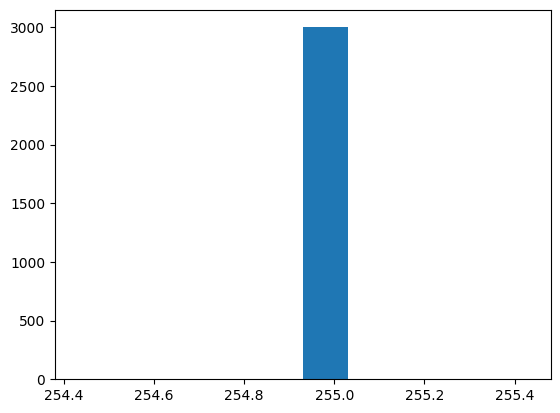

In [121]:
plt.hist(jnp.rad2deg(azimuth))

(array([135., 500., 223.,  67.,  26., 138., 257., 255., 157.,  32.]),
 array([ 99.35689754, 107.42120779, 115.48551803, 123.54982828,
        131.61413852, 139.67844877, 147.74275902, 155.80706926,
        163.87137951, 171.93568975, 180.        ]),
 <BarContainer object of 10 artists>)

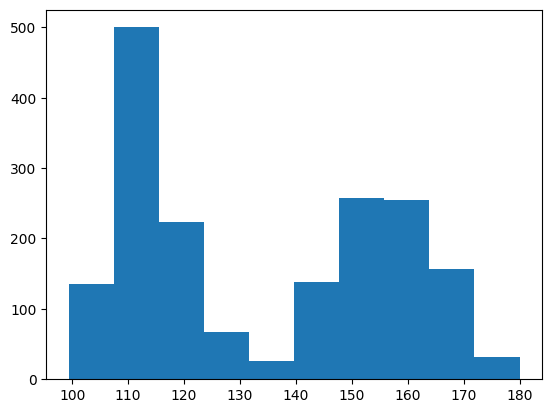

In [122]:
plt.hist(jnp.rad2deg(zenith))

In [95]:
jnp.rad2deg(jnp.median(samples['azimuth']))

Array(212.58198704, dtype=float64)

In [96]:
jnp.rad2deg(track_src)

Array([126.11328806, 231.75320629], dtype=float64)

In [53]:
results.termination_reason

Array(4, dtype=int64)

In [58]:
results.samples

{}

In [54]:

n_chains = 100

rng_key = jax.random.key(0)

warmup = blackjax.chees_adaptation(log_p, n_chains)
key_warmup, key_sample = jax.random.split(rng_key)
optim = optax.adam(learning_rate=0.01)

#track_src_init = jnp.deg2rad(jnp.array([131.5, 218]))
track_src_init = track_src

#track_pos_init = centered_track_pos + 30.0
track_pos_init = centered_track_pos

x0 = jnp.concatenate([track_src_init*scale_rad, track_pos_init/scale])
x0 = jnp.repeat(jnp.expand_dims(x0, axis=0), n_chains, axis=0)

initial_step_size = 0.2
num_warmup_steps = 1000


start = time.time()

(last_states, parameters), warmup_samples = warmup.run(
    key_warmup,
    x0,
    initial_step_size,
    optim,
    num_warmup_steps,
)

print(last_states[0].shape)
end = time.time()

print(end-start)

NameError: name 'scale_rad' is not defined

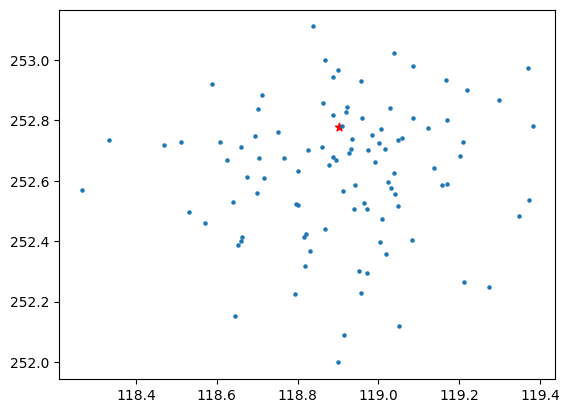

In [84]:
plt.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red')
x = np.rad2deg(last_states[0][:, :2] / scale_rad)
plt.scatter(x[:,0], x[:,1], s=5)

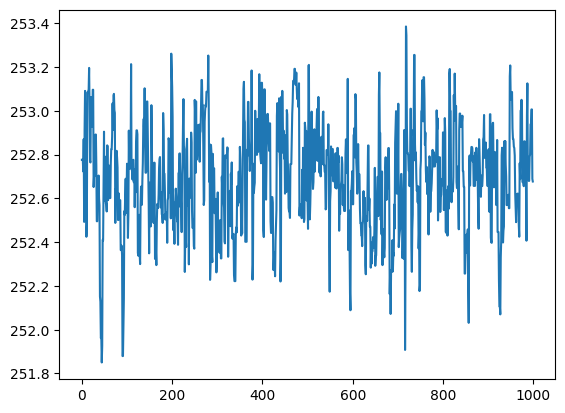

In [85]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 0, 1] / scale_rad))

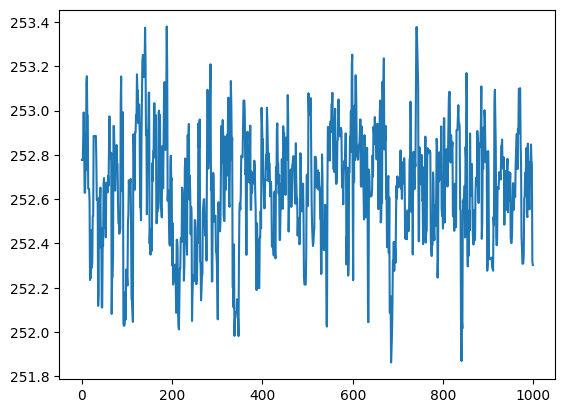

In [86]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 1, 1] / scale_rad))

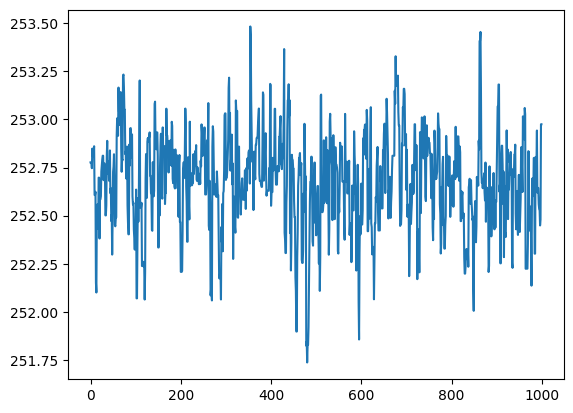

In [87]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 2, 1] / scale_rad))

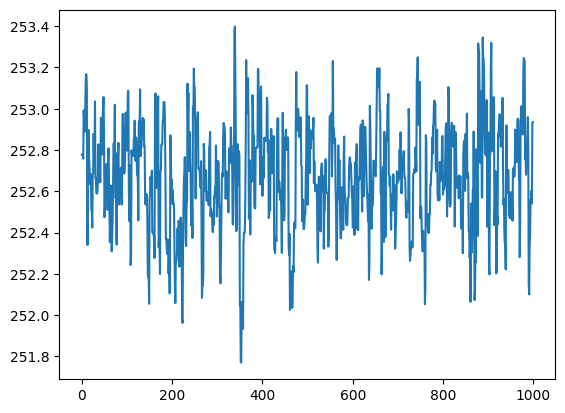

In [88]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 3, 1] / scale_rad))

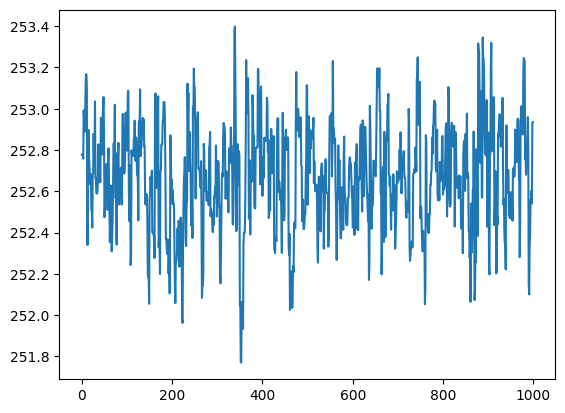

In [89]:
plt.plot(np.arange(num_warmup_steps), np.rad2deg(warmup_samples[0].position[:, 3, 1] / scale_rad))


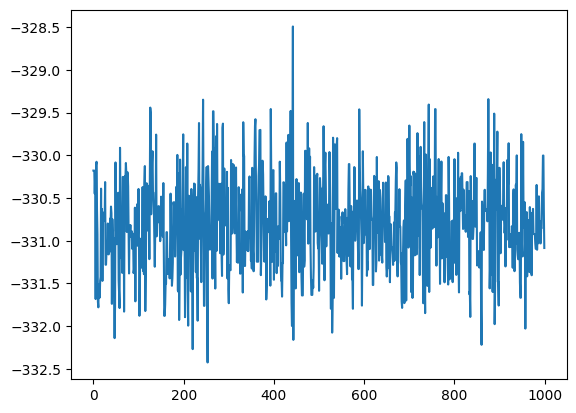

In [90]:
plt.plot(np.arange(num_warmup_steps), warmup_samples[0].position[:, 0, 4] * scale)

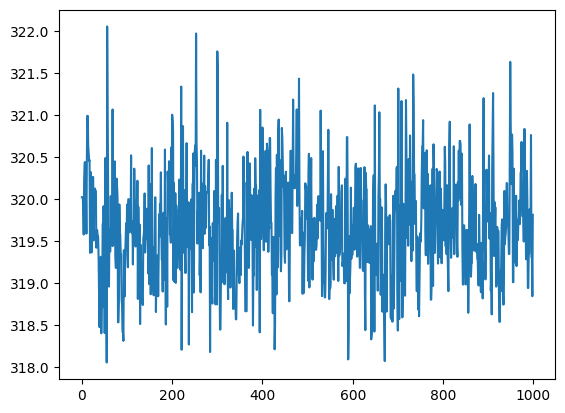

In [91]:
plt.plot(np.arange(num_warmup_steps), warmup_samples[0].position[:, 0, 3] * scale)

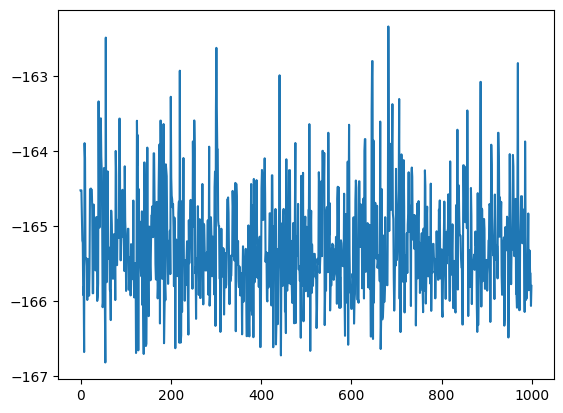

In [92]:
plt.plot(np.arange(num_warmup_steps), warmup_samples[0].position[:, 0, 2] * scale)

In [93]:
kernel = blackjax.dynamic_hmc(log_p, **parameters).step
#new_states, info = jax.vmap(kernel)(chain_keys, last_states)

In [94]:
def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [95]:
import time

start = time.time()

states = inference_loop_multiple_chains(
    key_sample, kernel, last_states, 100, n_chains
)

print(states.position[:, :, :2].shape)

end = time.time()

print(end - start)

(100, 100, 2)
14.813647747039795


In [96]:
states.position.shape

(100, 100, 5)

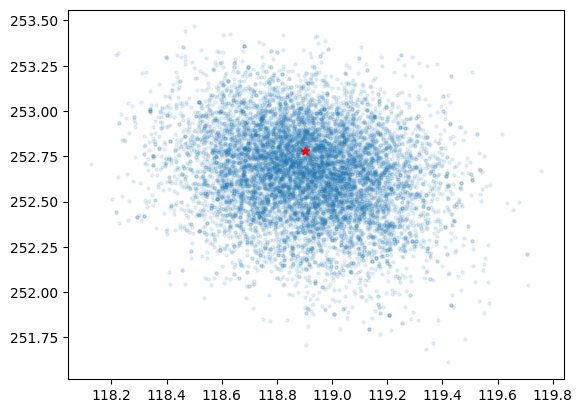

In [97]:
x = np.rad2deg(states.position[:, :, :2] / scale_rad)
plt.scatter(x[:, :, 0], x[:, : ,1], s=5, alpha = 0.1)
plt.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red')

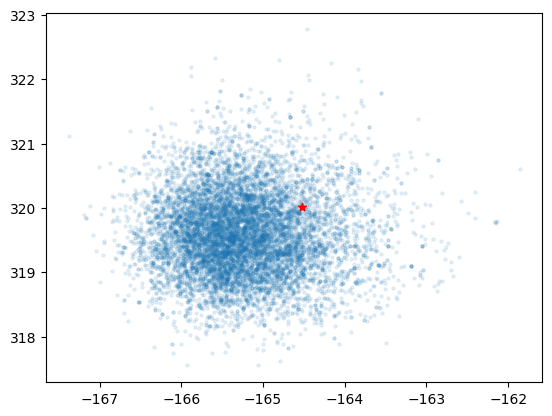

In [98]:
x = states.position[:, :, 2:] * scale
plt.scatter(x[:, :, 0], x[:, : ,1], s=5, alpha = 0.1)
plt.scatter(centered_track_pos[0], centered_track_pos[1], marker="*", color='red')

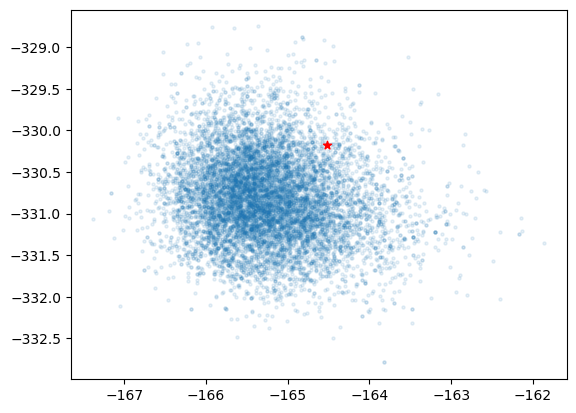

In [99]:
x = states.position[:, :, 2:] * scale
plt.scatter(x[:, :, 0], x[:, : ,2], s=5, alpha = 0.1)
plt.scatter(centered_track_pos[0], centered_track_pos[2], marker="*", color='red')

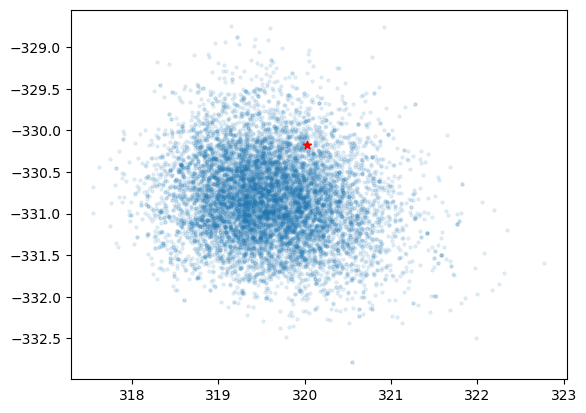

In [100]:
x = states.position[:, :, 2:] * scale
plt.scatter(x[:, :, 1], x[:, : ,2], s=5, alpha = 0.1)
plt.scatter(centered_track_pos[1], centered_track_pos[2], marker="*", color='red')

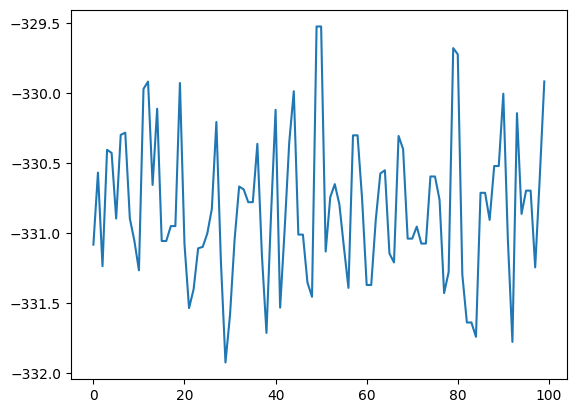

In [101]:
plt.plot(np.arange(100), states.position[:, 0, 4] * scale)

In [179]:
from jax.scipy.stats import gaussian_kde
x = np.rad2deg(states.position[:, :, :2] / scale_rad)

In [180]:
x = x.reshape((x.shape[0]*x.shape[1], 2)).T

In [181]:
kde = gaussian_kde(x, 0.3)

In [182]:
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=True, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

In [183]:
dzen = 0.02
dazi = 0.02
n_eval = 500

zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(jnp.rad2deg(zenith), jnp.rad2deg(azimuth))

In [184]:
x = jnp.concatenate([jnp.expand_dims(X.flatten(), axis=0), jnp.expand_dims(Y.flatten(), axis=0)], axis=0)

In [185]:
z = kde.evaluate(x)

In [186]:
z = z.reshape(X.shape)

In [187]:
track_src

Array([2.07523752, 4.41178695], dtype=float64)

In [188]:
X.shape

(500, 500)

In [189]:
x = np.rad2deg(states.position[:, :, :2] / scale_rad)
x = x.reshape((x.shape[0]*x.shape[1], 2))

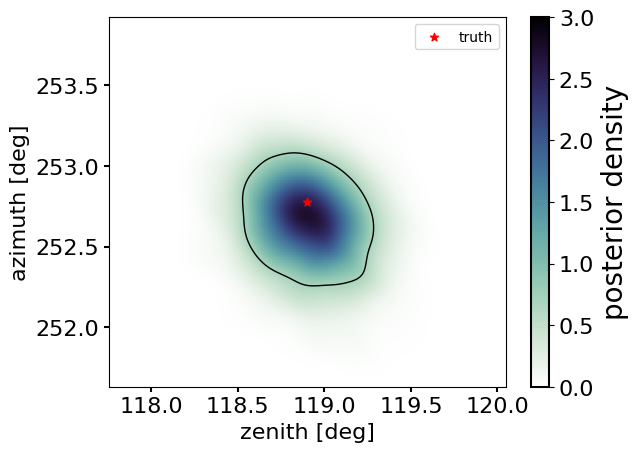

In [203]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(X, Y, z, vmin=0, vmax=3.0, shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("posterior density", fontsize=20)
cbar.outline.set_linewidth(1.5)

#ax.scatter(x[:, 0], x[:, 1], s=2, alpha=0.05)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)
ct = plt.contour(X, Y, z, levels=[0.7], linestyles=['solid'], colors=['black'], linewidths=1.0)

plt.legend()
plt.show()

In [191]:
z

Array([[1.04913391e-35, 2.23437902e-35, 4.73594662e-35, ...,
        9.24514697e-13, 7.06965790e-13, 5.38124449e-13],
       [1.66283554e-35, 3.53837135e-35, 7.49344563e-35, ...,
        1.21866346e-12, 9.31226705e-13, 7.08299304e-13],
       [2.62554496e-35, 5.58215355e-35, 1.18115839e-34, ...,
        1.60048304e-12, 1.22208619e-12, 9.28824617e-13],
       ...,
       [1.30118091e-22, 1.88628941e-22, 2.72152486e-22, ...,
        5.32239669e-43, 2.67437439e-43, 1.33739930e-43],
       [8.65321487e-23, 1.25338973e-22, 1.80687493e-22, ...,
        2.69480819e-43, 1.35291582e-43, 6.75985862e-44],
       [5.73295665e-23, 8.29708010e-23, 1.19510265e-22, ...,
        1.35924934e-43, 6.81820409e-44, 3.40380590e-44]], dtype=float64)

In [192]:
X

Array([[117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       ...,
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723]], dtype=float64)

In [193]:
X

Array([[117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       ...,
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723],
       [117.75643605, 117.7610289 , 117.76562175, ..., 120.03908153,
        120.04367438, 120.04826723]], dtype=float64)

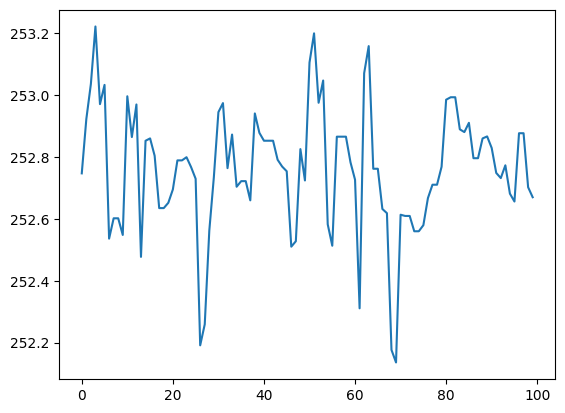

In [194]:
plt.plot(np.arange(100), jnp.rad2deg(states.position[:, 73, 1] / scale_rad))

In [195]:
kde_vals = kde(x.T)

In [196]:
kde_vals_sorted = kde_vals.copy()

In [197]:
kde_vals_sorted.sort()
kde_vals_sorted = kde_vals_sorted[::-1]
n_total = len(kde_vals_sorted)

In [198]:
fracs = np.zeros_like(kde_vals_sorted)

In [199]:
for i, val in enumerate(kde_vals_sorted):
    fracs[i] = i / float(n_total)

In [200]:
kde_vals_sorted

Array([0.32176917, 1.05168515, 1.03078202, ..., 0.52742689, 1.43577293,
       2.72383287], dtype=float64)

In [201]:
idx = np.searchsorted(fracs, 0.9, side='left', sorter=None)

In [202]:
print(idx, fracs[idx], kde_vals_sorted[idx])

9000 0.9 0.6884247058527997


In [232]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm
import matplotlib
from matplotlib import ticker

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    vmin=vals.min()
    vmax=vals.max() 
    cmap = plt.get_cmap("cubehelix", 20)
    norm = Normalize( vmin=vmin, vmax=vmax )
   
    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap=cmap).to_rgba( val ) for val in vals]
    cbar_probs = [norm, cmap, vmin, vmax]

    return colours, cbar_probs

colours, cbar_probs = makeColours( kde_vals )


In [233]:
x.shape

(10000, 2)

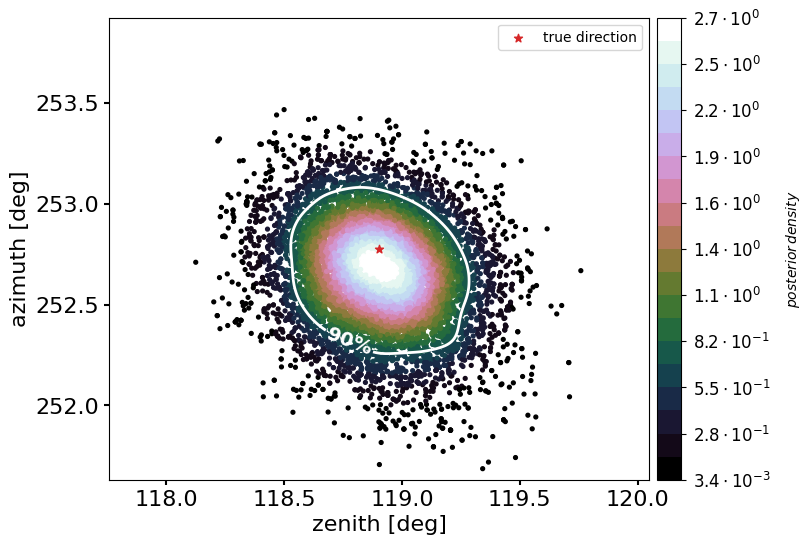

In [251]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# sub sample
plt.scatter(x[:, 0], x[:,1 ], marker=".", color=colours, s=30, )
ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='tab:red', label="true direction", zorder=200)
ct = plt.contour(X, Y, z, levels=[0.7], linestyles=['solid'], colors=['white'], linewidths=2.0)
labels=['$\\mathbf{90\\%}$']
fmt={}
for l,s in zip( ct.levels, labels ):
        fmt[l] = s
plt.clabel(ct, ct.levels, inline=1, fontsize=14, fmt=fmt, colors=['white'])

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

#ax.yaxis.set_label_coords(-0.15, 1.)
#ax.xaxis.set_label_coords(1.0, -0.12)
ax.legend()

def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${}\cdot 10^{{{}}}$'.format(a, b)


fig.subplots_adjust(right=0.8)
cbar_ax1 = fig.add_axes([0.81, 0.11, 0.03, 0.77])
cbar = mpl.colorbar.ColorbarBase(cbar_ax1, format=ticker.FuncFormatter(fmt), spacing='uniform', 
                                 ticks=np.linspace(cbar_probs[2], cbar_probs[3],11), 
                                 cmap=cbar_probs[1], 
                                 norm=cbar_probs[0], 
                                 orientation='vertical')

cbar.set_label('$posterior\,density$', labelpad=10)
cbar.ax.tick_params(labelsize=12, pad=5)
cbar.update_ticks()

plt.show()

In [29]:
centered_track_pos

Array([ -53.74394146,  162.12452256, -233.73599134], dtype=float64)

In [10]:
beta1 = 0.9
beta2 = 0.99
learning_rate = 1.e-3

In [11]:
b1 = lambda beta1, kappa: 1-kappa*(1-beta1)
lr = lambda learning_rate, kappa: learning_rate / np.sqrt(kappa)

In [12]:
kappa = np.linspace(1, 20)

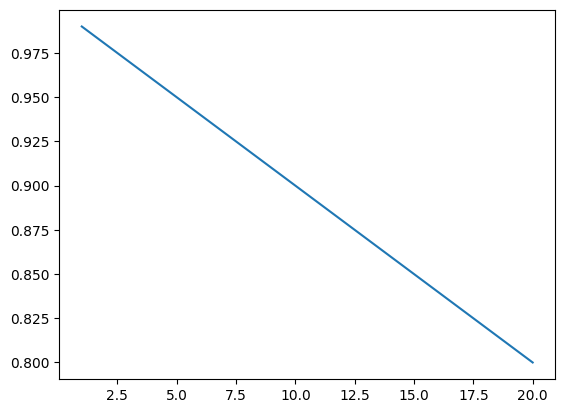

In [16]:
plt.plot(kappa, b1(beta2, kappa))